In [3]:
#Task 1: Finding rectangles
#A nice blog-post by Johannes Rieke presents a simple setup from scratch that finds rectangles in a black & white image. 
#In order to play with it, we just have to translate a few calls from Keras to PyTorch.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

ModuleNotFoundError: No module named 'torch'

In [2]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [3]:
#Task 1a
#Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. 
#have a fully connected, hidden layer with 200 neurons, 
#ReLU nonlinearity and dropout rate of 20%.

In [4]:
# Build the model.
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# N, D_in, H, D_out = 64, 1000, 100, 10

# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, D_out),
# )
H = 200
model = torch.nn.Sequential(
    torch.nn.Linear(X.shape[-1], H).cuda(),
    #torch.nn.Linear(X.shape[-1], H), # Uncomment this to run on CPU
    torch.nn.ReLU(),
    #torch.nn.AlphaDropout(p=0.2),
    torch.nn.Dropout2d(p=0.2),
    torch.nn.Linear(H, y.shape[-1]).cuda(),
    #torch.nn.Linear(H, y.shape[-1]),# Uncomment this to run on CPU
)

In [5]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
#optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.Adadelta(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

In [6]:
#dtype = torch.FloatTensor # Uncomment this to run on CPU
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [7]:
# inputs = Variable(torch.Tensor(train_X))# Uncomment this to run on CPU
# labels = Variable(torch.Tensor(train_y))# Uncomment this to run on CPU

inputs = Variable(torch.Tensor(train_X).type(dtype))
labels = Variable(torch.Tensor(train_y).type(dtype))

In [8]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(800):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data[0] * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

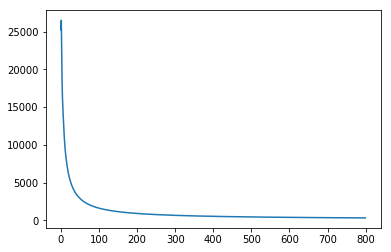

In [9]:
plt.plot(loss_record)

In [10]:
# Predict bounding boxes on the test images.
#pred_y = model(Variable(torch.Tensor(test_X))) #uncomment when use CPU
pred_y = model(Variable(torch.Tensor(test_X).type(dtype)))
pred_y = pred_y.cpu() # Uncomment when use GPU, transfers it to CPU, back to being a torch.FloatTensor
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape


(10000, 1, 4)

In [11]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.6719386199922796

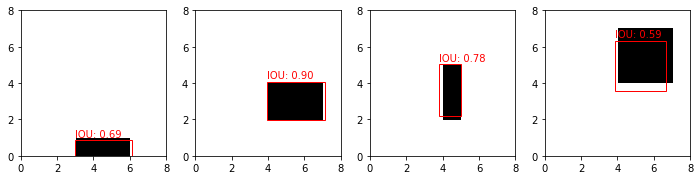

In [12]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU


In [627]:
#Task 1b:
#Move the computation that is currently done on the CPU over to the GPU using CUDA and 
#increase the number of epochs. Improve the training setup until you reach an IOU of above 0.6. 
#You can make the changes that move computation to the GPU directly in the cells above.

In [628]:
#Task 2: Use a pretrained model
#As mentioned in class deep learning systems are 
#hardly ever developed from scratch, but usually work 
#by refining existing solutions to similar problems. 
#For the following task, we'll work through the Transfer learning tutorial, 
#which also provides a ready-made jupyter notebook.

In [629]:
# Download the notebook and get it to run in your environment. 
# This also involves downloading the bees and ants dataset.
# Perform your own training with the provided setup.
# Change the currently chosen pretrained network (resnet) to 
# a different one. At least try out VGG and one other type.
# Load a picture that you took yourself and classify it with 
# an unmodified pretrained network (e.g. the original VGG network) 
# that can detect one out of 1000 classes.

In [630]:
# Hints for step 3
# Focus on the section Conv net as fixed feature xtractor of the transfer learning tutorial. First, change the line

# model_conv = torchvision.models.resnet18(pretrained=True)
# to load VGG19 instead.

# Next, print out the new model_conv and identify the last step 
#of the classification. 
#This is not named the same way as the fc layer for resnet, but works similarity. Identify the module that contains the last classification step of the VGG model, which identifies one out of 1000 classes. Change that one into identifying 2 classes only (i.e. the ants and bees that you should start with).

# To change the structure of a hypothetical sequential component called module_name and modify its last layer into a DifferentLayer type, you can use this syntax.

# nn.Sequential(*list(model_conv.module_name.children())[:-1] +
#                      [nn.DifferentLayer(...)])
# and replace the old model_conv.module_name with the differently structured version.

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/shared/CMPT/big-data/tmp_py/dlenv/lib/python3.6/site-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/shared/CMPT/big-data/tmp_py/dlenv/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


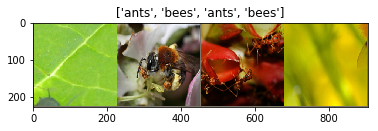

In [3]:
# Visualize a few images ^^^^^^^^^^^^^^^^^^^^^^ Let's visualize 
# a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
# Training the model
# Now, let's write a general function to train a model. Here, we will illustrate:
# Scheduling the learning rate
# Saving the best model
# In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# Visualizing the model predictions ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Generic function to display predictions for a few images

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [32]:
#Finetuning the convnet
#Load a pretrained model and reset final fully connected layer.
# ConvNet as fixed feature extractor
# Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().
# You can read more about this in the documentation here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>__.

In [34]:
model_vgg19 = torchvision.models.vgg19(pretrained=True)

In [40]:
model_vgg19.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000)
)

In [14]:
#model_resnet = models.resnet18(pretrained=True)
#model_ft = models.alexnet(pretrained=True) # other pretrained networks
model_vgg19 = torchvision.models.vgg19(pretrained=True)
for param in model_vgg19.parameters():
    param.requires_grad = False

model_vgg19.classifier._modules['6']=nn.Linear(4096,2)

In [15]:
# model_ft = models.resnet18(pretrained=True)

# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)

# if use_gpu:
#     model_ft = model_ft.cuda()

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


if use_gpu:
    model_vgg19 = model_vgg19.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_vgg19 = optim.SGD(model_vgg19.classifier._modules['6'].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg19, step_size=7, gamma=0.1)

In [34]:
# Train and evaluate ^^^^^^^^^^^^^^^^^^
# It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.
#This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [16]:
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
model_vgg19 = train_model(model_vgg19, criterion, optimizer_vgg19, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2343 Acc: 0.9057
val Loss: 0.1628 Acc: 0.9630

Epoch 1/24
----------
train Loss: 0.2210 Acc: 0.9262
val Loss: 0.1055 Acc: 0.9722

Epoch 2/24
----------
train Loss: 0.1779 Acc: 0.9303
val Loss: 0.1068 Acc: 0.9722

Epoch 3/24
----------
train Loss: 0.2171 Acc: 0.9180
val Loss: 0.1179 Acc: 0.9537

Epoch 4/24
----------
train Loss: 0.1758 Acc: 0.9344
val Loss: 0.1561 Acc: 0.9630

Epoch 5/24
----------
train Loss: 0.1525 Acc: 0.9344
val Loss: 0.1220 Acc: 0.9722

Epoch 6/24
----------
train Loss: 0.1874 Acc: 0.9508
val Loss: 0.1415 Acc: 0.9630

Epoch 7/24
----------
train Loss: 0.0792 Acc: 0.9836
val Loss: 0.1399 Acc: 0.9722

Epoch 8/24
----------
train Loss: 0.0661 Acc: 0.9631
val Loss: 0.1465 Acc: 0.9722

Epoch 9/24
----------
train Loss: 0.0945 Acc: 0.9754
val Loss: 0.1395 Acc: 0.9722

Epoch 10/24
----------
train Loss: 0.1388 Acc: 0.9508
val Loss: 0.1384 Acc: 0.9722

Epoch 11/24
----------
train Loss: 0.0992 Acc: 0.9672
val Loss: 0.1329 Acc: 0.9722

Ep

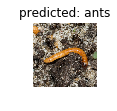

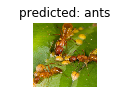

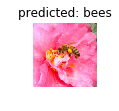

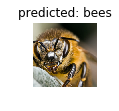

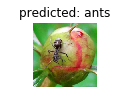

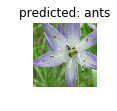

In [17]:
visualize_model(model_vgg19)

In [68]:
#Trying to use a different model DENSENET161
# Again Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().
model_densenet161 = torchvision.models.densenet161(pretrained=True)

In [69]:
#model_densenet161

In [70]:
model_densenet161.classifier

Linear(in_features=2208, out_features=1000)

In [71]:
for param in model_densenet161.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_densenet161.classifier.in_features
num_ftrs

2208

In [72]:
model_densenet161.classifier = nn.Linear(num_ftrs, 2)

model_densenet161.classifier

Linear(in_features=2208, out_features=2)

In [73]:
if use_gpu:
    model_densenet161 = model_densenet161.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_densenet161 = optim.SGD(model_densenet161.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_densenet161, step_size=7, gamma=0.1)

In [74]:
model_densenet161 = train_model(model_densenet161, criterion, optimizer_densenet161, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5718 Acc: 0.6926
val Loss: 0.2106 Acc: 0.9352

Epoch 1/24
----------
train Loss: 0.3801 Acc: 0.8279
val Loss: 0.0825 Acc: 0.9722

Epoch 2/24
----------
train Loss: 0.4596 Acc: 0.8197
val Loss: 0.0872 Acc: 0.9630

Epoch 3/24
----------
train Loss: 0.5441 Acc: 0.7910
val Loss: 0.0592 Acc: 0.9815

Epoch 4/24
----------
train Loss: 0.4605 Acc: 0.8197
val Loss: 0.4284 Acc: 0.8611

Epoch 5/24
----------
train Loss: 0.3237 Acc: 0.8893
val Loss: 0.0534 Acc: 0.9722

Epoch 6/24
----------
train Loss: 0.3840 Acc: 0.8361
val Loss: 0.0555 Acc: 0.9815

Epoch 7/24
----------
train Loss: 0.2477 Acc: 0.8893
val Loss: 0.0660 Acc: 0.9722

Epoch 8/24
----------
train Loss: 0.2333 Acc: 0.9139
val Loss: 0.0452 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2704 Acc: 0.8934
val Loss: 0.0573 Acc: 0.9907

Epoch 10/24
----------
train Loss: 0.2564 Acc: 0.8811
val Loss: 0.0520 Acc: 0.9907

Epoch 11/24
----------
train Loss: 0.3671 Acc: 0.8402
val Loss: 0.0549 Acc: 1.0000

Ep

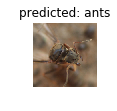

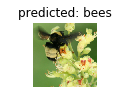

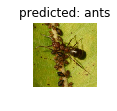

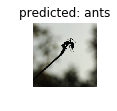

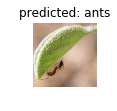

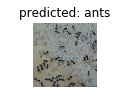

In [75]:
visualize_model(model_densenet161)

In [ ]:
#4) Load a picture that you took yourself and classify it with an unmodified pretrained 
#network (e.g. the original VGG network) that can detect one out of 1000 classes.

In [18]:
from PIL import Image

In [19]:
img = Image.open('index.jpeg')

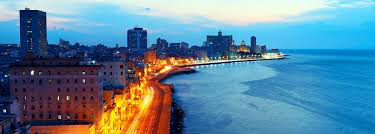

In [20]:
img

In [21]:
#vgg19 = models.vgg19(pretrained = True).cuda()
vgg19 = models.vgg19(pretrained = True).cuda()

In [22]:
img_tensor = data_transforms['val'](img)

In [23]:
inputs = Variable(img_tensor.cuda().unsqueeze_(0))

In [24]:
outputs = vgg19(inputs)
_, preds = torch.max(outputs.data, 1)

In [25]:
torch.max(outputs.data, 1)

(
  9.8711
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
  718
 [torch.cuda.LongTensor of size 1 (GPU 0)])

In [82]:
#Checking in a different way
o = outputs.data.cpu().numpy()
o.argmax()

718

In [28]:
url = "https://s3.amazonaws.com/outcome-blog/imagenet/labels.json"
import requests
labels = {int(key):value for (key,value)
         in requests.get(url).json().items()}

In [29]:
# What have been predicted:
labels[int(preds)]

'pier'